# Hyperband Automatic Model Tuning for Distributed Training


---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-west-2/hyperparameter_tuning|model_tuning_for_distributed_training|hyperparameter_tuning_for_distributed_training.ipynb)

---

This project is based on the [HPO XGBoost notebook](https://github.com/aws/amazon-sagemaker-examples/blob/main/hyperparameter_tuning/xgboost_direct_marketing/hpo_xgboost_direct_marketing_sagemaker_python_sdk.ipynb)

---

Kernel `Python 3 (Data Science)` works well with this notebook.

## Contents

1. [Background](#Background)
1. [Preparation](#Preparation)
1. [Data Downloading and Transformation](#Data_Downloading)
1. [Demo setup](#Demo_setup)  
1. [Run Demo](#Run_Demo)  
1. [Setup Hyperparameter Tuning](#Setup_Hyperparameter_Tuning)
1. [Launch Hyperparameter Tuning](#Launch_Hyperparameter_Tuning)
1. [Analyze Hyperparameter Tuning Results](#Analyze_Hyperparameter_Tuning_Results)
1. [Tuning with multiple scaling options](#Tuning_with_multiple_scaling_options)


---

## Background
With increased adoption of XXL models such as LLMs and Generative AI, distributed training is becoming a standard method for model training: using data parallelism to scale over multiple nodes and workers and model parallelism in order to fit the actual models on designated infrastructure. Amazon SageMaker has continuously innovated in this space by launching features like Heterogeneous Clusters and Distributed training Library.
However, moving from single to distributed environment has an impact on training hyperparameters which, in turn, impact model accuracy.  
Thus, distributed training needs to balance 3 vectors: distribution, hyperparameters and accuracy.

This notebook will demo the need for Hyperparameter Optimization (HPO) when moving from single to distributed environment, and show how to configure a SageMaker Automatic Model Tuning (AMT) job using Hyperband strategy.
We will train a model which can be used to predict if a customer will enroll for a term deposit at a bank, after one or more phone calls. Hyperparameter tuning will be used in order to try multiple hyperparameter settings and produce the best model.

We will use SageMaker Python SDK, a high level SDK, to simplify the way we interact with SageMaker Hyperparameter Tuning.

---



## Preparation

Let's start by:
- Installing latest SageMaker SDK 
- Specifying the S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as SageMaker training.
- Specifying the IAM role used to give training access to your data. See SageMaker documentation for how to create these.

In [ ]:
! pip install sagemaker --upgrade --quiet

In [ ]:
import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
    StrategyConfig,
    HyperbandStrategyConfig,
)

from sagemaker.inputs import TrainingInput
from sagemaker.s3 import S3Downloader

import numpy as np  # For matrix operations and numerical processing
import pandas as pd  # For munging tabular data
import os
from time import gmtime, strftime

region = boto3.Session().region_name
smclient = boto3.Session().client("sagemaker")

role = sagemaker.get_execution_role()

bucket = sagemaker.Session().default_bucket()
prefix = "sagemaker/DEMO-dist-hpo-xgboost-dm"
bucket

---

## Data Downloading and Transformation
In the next few cells we will download and prepare our data for training.  
Let's start by downloading the [direct marketing dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing).

In [ ]:
s3_uri = "s3://sagemaker-sample-files/datasets/tabular/uci_bank_marketing/bank-additional-full.csv"
S3Downloader.download(
    s3_uri, local_path="./bank-additional/", sagemaker_session=sagemaker.Session()
)

Next, we will read into a Pandas data frame and take a look.

In [ ]:
!ls -lh ./bank-additional/bank-additional-full.csv

In [ ]:
data = pd.read_csv("./bank-additional/bank-additional-full.csv", sep=",")
pd.set_option("display.max_columns", 500)  # Make sure we can see all of the columns
pd.set_option("display.max_rows", 50)  # Keep the output on one page
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


Some high level description of the data used:

* We have a little over 40K customer records, and 20 features for each customer
* The features are mixed; some numeric, some categorical
* The data appears to be sorted, at least by `time` and `contact`, maybe more
* It includes features related to customer demographics, past events (like credit defaults and loans) and past campaigns

The target variable `y` indicates whether the client has subscribed a term deposit (binary: 'yes','no').  
For more details on this data set, please see the original [HPO XGBoost notebook.](https://github.com/aws/amazon-sagemaker-examples/blob/main/hyperparameter_tuning/xgboost_direct_marketing/hpo_xgboost_direct_marketing_sagemaker_python_sdk.ipynb)  


### Data_Transformation
Our next steps will be to prepare our data for training.   
Because data preparation is not the focus of this example, we will not elaborate on these steps, but they include: feature encoding, grouping and feature selection.  
For detailed explanation about these steps please see the original [HPO XGBoost notebook.](https://github.com/aws/amazon-sagemaker-examples/blob/main/hyperparameter_tuning/xgboost_direct_marketing/hpo_xgboost_direct_marketing_sagemaker_python_sdk.ipynb)  


In [ ]:
data["no_previous_contact"] = np.where(
    data["pdays"] == 999, 1, 0
)  # Indicator variable to capture when pdays takes a value of 999

data["not_working"] = np.where(
    np.in1d(data["job"], ["student", "retired", "unemployed"]), 1, 0
)  # Indicator for individuals not actively employed

model_data = pd.get_dummies(data)  # Convert categorical variables to sets of indicators
model_data = model_data.drop(
    ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
    axis=1,
)
model_data

## Demo_setup
In the next few cells we will prepare the data for demoing how scaling out training, without hyperparameter tuning impacts model performance.  
In this experiment we will train an xgboost model once on a single instance and once using 3 instances.

We'll then split the dataset into training (85%), validation (5%), and test (10%) datasets and convert the datasets to the right format the algorithm expects. We will use training and validation datasets during training. Test dataset can be used to evaluate model performance after it is deployed to an endpoint.

In [ ]:
train_data, validation_data, test_data = np.split(
    model_data.sample(frac=1, random_state=1729),
    [int(0.85 * len(model_data)), int(0.9 * len(model_data))],
)

For the purpose of having a meaningful distributed training job, we will replicate our initial training and validation dataset by a factor of 100, and then shuffle the records in place. 

In [ ]:
replicated_df = pd.DataFrame(np.repeat(train_data.values, 100, axis=0))
replicated_df.columns = train_data.columns
train_data = replicated_df
train_data = train_data.sample(frac=1).reset_index(drop=True)

In [ ]:
replicated_df = pd.DataFrame(np.repeat(validation_data.values, 100, axis=0))
replicated_df.columns = validation_data.columns
validation_data = replicated_df
validation_data = validation_data.sample(frac=1).reset_index(drop=True)

As we are using SageMaker built-in XGBoost algorithm, the first column must be the target variable.  Also, notice that although repetitive it's easiest to do this after the train|validation|test split rather than before.  This avoids any misalignment issues due to random reordering.

In [ ]:
train_data = pd.concat([train_data["y_yes"], train_data.drop(["y_no", "y_yes"], axis=1)], axis=1)

In [ ]:
pd.concat(
    [validation_data["y_yes"], validation_data.drop(["y_no", "y_yes"], axis=1)], axis=1
).to_csv("validation.csv", index=False, header=False)

pd.concat([test_data["y_yes"], test_data.drop(["y_no", "y_yes"], axis=1)], axis=1).to_csv(
    "test.csv", index=False, header=False
)

Next, we will need to split our training data into multiple files. 
[SageMaker Documentation](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_S3DataSource.html) says this on how files are distributed in multi-instance training:  
> If there are n ML compute instances launched for a training job, each instance gets approximately 1/n of the number of S3 objects. In this case, model training on each machine uses only the subset of training data.

Please note: You shouldn't choose more ML compute instances for training than available S3 objects. If you do, some nodes won't get any data, and you will pay for nodes that aren't getting any training data. This applies in both File and Pipe modes. Keep this in mind when developing algorithms.

For this example, we will use 3 instances for the distributed training job, thus we will split our training set to 3 files.

In [ ]:
max_instances = 3
for indx, partition in enumerate(np.array_split(train_data, max_instances)):
    partition.to_csv(f"train_{indx}.csv", index=False, header=False)

Next, upload the files to S3.

In [ ]:
import glob

trainingFiles = glob.glob("train_*.csv")
for trainingFile in trainingFiles:
    osPath = os.path.join(prefix, "train/{}".format(trainingFile))
    print(osPath)
    boto3.Session().resource("s3").Bucket(bucket).Object(osPath).upload_file(trainingFile)

Now we'll copy the validation file to S3 for Amazon SageMaker training to pickup.

In [ ]:
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "validation/validation.csv")
).upload_file("validation.csv")

Finally, we will set the train and validation input channels.   


In distributed training, where you use multiple ML compute instances, you should choose ```ShardedByS3Key```. If the algorithm requires copying training data to the ML storage volume (when TrainingInputMode is set to File), this copies 1/n of the number of objects.

In [ ]:
s3_input_train = TrainingInput(
    distribution="ShardedByS3Key",
    s3_data="s3://{}/{}/train".format(bucket, prefix),
    content_type="csv",
)
s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/validation/".format(bucket, prefix), content_type="csv"
)

print(s3_input_train.config["DataSource"]["S3DataSource"]["S3Uri"])
print(s3_input_validation.config["DataSource"]["S3DataSource"]["S3Uri"])

## Run_Demo

Now that our data is ready and channels configured, we'll run a quick experiment: run single Vs. distributed training and observe the effect on model convergence.  
  
Let's start by defining a simple function to build our estimator.  
In this example, we are using SageMaker Python SDK to configure the training job, which includes:

* The container image for the algorithm (XGBoost)
* Configuration for the output of the training jobs
* The values of static algorithm hyperparameters, those that are not specified will be given default values
* The type and number of instances to use for the training jobs

In [214]:
def get_XGB_estimnator(instnaces=1):
    container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, "latest")

    max_run = 2400
    max_wait = 3600

    xgbEstimator = sagemaker.estimator.Estimator(
        container,
        role,
        instance_count=instnaces,
        instance_type="ml.m5.2xlarge",
        output_path="s3://{}/{}/output".format(bucket, prefix),
        sagemaker_session=sagemaker.Session(),
        # use_spot_instances=True,
        # max_run=max_run,
        # max_wait=max_wait,
    )

    xgbEstimator.set_hyperparameters(
        eval_metric="auc",
        objective="binary:logistic",
        num_round=150,
        rate_drop=0.0,
        tree_method="exact",
        eta=0.3,
        colsample_bylevel=0.5,
        colsample_bytree=0.8,
    )
    return xgbEstimator

### Run single instance training
Lets' start by running the single instance job first. 

In [ ]:
xgb = get_XGB_estimnator()
training_job_name = "xgb-single-instance-{}".format(strftime("%Y-%m-%d-%H-%M-%S", gmtime()))
xgb.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
    job_name=training_job_name,
    wait=True,
)

You can see the job progress in the SageMaker console.  
Once the job is done, we will use the estimator's ```training_job_analytics``` API to retrieve model performance.

In [218]:
single_df = xgb.training_job_analytics.dataframe(force_refresh=False)
single_df

,timestamp,metric_name,value
0,0.0,validation:auc,0.764708
1,60.0,validation:auc,0.781512
2,120.0,validation:auc,0.782427
3,180.0,validation:auc,0.783452
4,0.0,train:auc,0.769453
5,60.0,train:auc,0.829521
6,120.0,train:auc,0.874340
7,180.0,train:auc,0.900571


While some variations can occur, in the current run we see training took 180 seconds (3 minutes) with train:auc of 0.90 and validation:auc at 0.78.

## Run distributed training - not optimized
Now, we'll run the training job in distributed mode but with no change to the hyperparameters.

In [ ]:
xgb3 = get_XGB_estimnator(3)
training_job_name = "xgb-3-instances-{}".format(strftime("%Y-%m-%d-%H-%M-%S", gmtime()))

xgb3.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
    wait=True,
    job_name=training_job_name,
)

In [217]:
dist_df = xgb3.training_job_analytics.dataframe(force_refresh=True)
dist_df

,timestamp,metric_name,value
0,0.0,validation:auc,0.668060
1,60.0,validation:auc,0.639962
2,0.0,train:auc,0.845573
3,60.0,train:auc,0.868916


As expected, the distributed training took about one minute, but the model suffered a drop in performance with train:auc 0.86 and validation:auc of 0.63! 

## Result discussion
There are a number of potential reasons why this happens.  
It was observed that both synchronous distribution algorithms like allreduce (which XGBoost uses) [might perform poorly](https://arxiv.org/pdf/1710.06952v3.pdf), as well as asynchronous distribution methods like parameter server also suffer significantly worse convergence [when traffic to parameter server is congested](https://arxiv.org/pdf/1710.06952v3.pdf). Additionally, for deep learning models, [weight staleness](https://www.cs.cmu.edu/~epxing/papers/2019/Dai_etal_ICLR19.pdf) and degradation in model quality due to [larger mini-batch size](https://arxiv.org/pdf/1609.04836.pdf) have been observed. 

---

## Setup_Hyperparameter_Tuning 
*Note, with the default setting below, the hyperparameter tuning job can take about 30 minutes to complete.*

We will use SageMaker hyperparameter tuning to automate the searching process effectively. Specifically, we specify a range, or a list of possible values in the case of categorical hyperparameters, for each of the hyperparameter that we plan to tune. SageMaker hyperparameter tuning will automatically launch multiple training jobs with different hyperparameter settings, evaluate results of those training jobs based on a predefined "objective metric", and select the hyperparameter settings for future attempts based on previous results. For each hyperparameter tuning job, we will give it a budget (max number of training jobs) and it will complete once that many training jobs have been executed.


We'll start by specifying the objective metric that we'd like to tune and its definition, which includes the regular expression (Regex) needed to extract that metric from the CloudWatch logs of the training job. Since we are using built-in XGBoost algorithm here, it emits two predefined metrics: *validation:auc* and *train:auc*, and we elected to monitor *validation:auc* as you can see below. In this case, we only need to specify the metric name and do not need to provide regex. If you bring your own algorithm, your algorithm emits metrics by itself. In that case, you'll need to add a MetricDefinition object here to define the format of those metrics through regex, so that SageMaker knows how to extract those metrics from your CloudWatch logs.

In [219]:
objective_metric_name = "validation:auc"

We will tune seven hyperparameters in this examples:
* *num_round*: The number of rounds for boosting during the training.
* *eta*: Step size shrinkage used in updates to prevent overfitting. After each boosting step, you can directly get the weights of new features. The eta parameter actually shrinks the feature weights to make the boosting process more conservative. 
* *alpha*: L1 regularization term on weights. Increasing this value makes models more conservative. 
* *min_child_weight*: Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, the building process gives up further partitioning. In linear regression models, this simply corresponds to a minimum number of instances needed in each node. The larger the algorithm, the more conservative it is. 
* *max_depth*: Maximum depth of a tree. Increasing this value makes the model more complex and likely to be overfitted. 
* *colsample_bylevel*: Subsample ratio of columns for each split, in each level. This subsampling takes place once for every new depth level reached in a tree.
* *colsample_bytree*: Subsample ratio of columns when constructing each tree. For every tree constructed the subsampling occurs once.

In [227]:
hyperparameter_ranges = {
    "num_round": IntegerParameter(100, 200),
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(1, 10),
    "colsample_bylevel": ContinuousParameter(0, 1),
    "colsample_bytree": ContinuousParameter(0, 1),
}

Next, we provide the Hyperband configuration.  



In [234]:
hsc = HyperbandStrategyConfig(max_resource=30, min_resource=1)
sc = StrategyConfig(hyperband_strategy_config=hsc)

Now, we'll create a `HyperparameterTuner` object, to which we pass:
- The XGBoost estimator we created above, set to run with 3 instances
- Objective metric name and definition
- Our hyperparameter ranges
- Tuning resource configurations such as Number of training jobs to run in total and how many training jobs can be run in parallel.
- Hyperband settings: strategy and configuration

Training jobs can be stopped early when they are unlikely to improve the objective metric of the hyperparameter tuning job. This can help reduce compute time and avoid overfitting your model. Hyperband uses an advanced internal mechanism to apply early stopping. Thus, the parameter TrainingJobEarlyStoppingType in the HyperParameterTuningJobConfig API must be set to OFF when using the Hyperband internal early stopping feature.  
- Early stopping set to off

In [235]:
tuner = HyperparameterTuner(
    xgb3,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=30,
    max_parallel_jobs=4,
    strategy="Hyperband",
    early_stopping_type="Off",
    strategy_config=sc,
)

## Launch_Hyperparameter_Tuning
Now we can launch a hyperparameter tuning job by calling *fit()* function. After the hyperparameter tuning job is created, we can go to SageMaker console to track the progress of the hyperparameter tuning job until it is completed.

In [ ]:
tuner.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
    include_cls_metadata=False,
    wait=True,
)

Let's just run a quick check of the hyperparameter tuning jobs status to make sure it started successfully.

In [ ]:
sm = boto3.client("sagemaker")
sm.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

## Analyze_Hyperparameter_Tuning_Results
Here we analyze the tuning job results - after tuning job is completed.


In [ ]:
tuning_job_name = tuner.latest_tuning_job.job_name
tuning_job_name

Let's see how good our tuned model did

In [246]:
tuner = HyperparameterTuner.attach(tuning_job_name=tuning_job_name)
tuner.describe()["BestTrainingJob"]["FinalHyperParameterTuningJobObjectiveMetric"]["Value"]

0.7859619855880737

Again, some variations may occur but you should see that the best job was able to optimize the model with over to 0.78 on the validation:auc!  


Let fetch results about a hyperparameter tuning job and make them accessible for analysis in a pandas data frame.


In [ ]:
tuner_analytics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner_analytics.dataframe()
full_df.sort_values(by=["FinalObjectiveValue"], ascending=False).head()

When running the training independently, we saw it took 4 minutes.  
Let's see the average time a training job took with Hyperband strategy.

In [248]:
full_df["TrainingElapsedTimeSeconds"].mean()

59.833333333333336

The average job took about 1 minute!  

Finally, we can further examine results to see how multiple parameters are related.

In [249]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

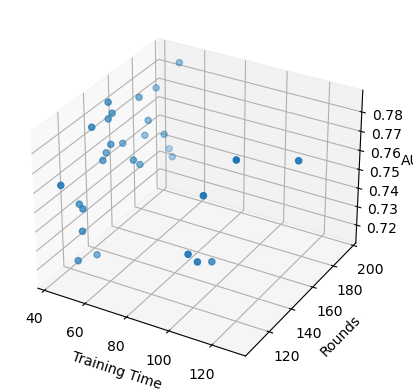

In [250]:
threedee = plt.figure().add_subplot(projection="3d")
threedee.scatter(
    full_df["TrainingElapsedTimeSeconds"], full_df["num_round"], full_df["FinalObjectiveValue"]
)
threedee.set_xlabel("Training Time")
threedee.set_ylabel("Rounds")
threedee.set_zlabel("AUC")
plt.show()

## Tuning_with_multiple_scaling_options

## <font color='red'>Danger Zone! Tread carefully beyond this point!</font>


The following is an example in case you also need to optimize the cluster size.
It will loop over a list of the required instance count you wish to test, and will spin a tuning job for each cluster size.  
<font color='red'>Please note</font>: this process may have a significant impact on account cost and limits because each tuner will launch jobs with multiple instances!  


In [ ]:
# max_instances = 5
# tuning_jobs=[]

# import time
# sm=boto3.client("sagemaker")

# def check_tuning_status(tuner_to_check):
#     status=sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuner_to_check.latest_tuning_job.job_name)["HyperParameterTuningJobStatus"]
#     return status


# In this example, we will test 3,4 and 5 instances
# for num_of_instances in range(3, max_instances+1):
#     xgb_estimator=get_XGB_estimnator(num_of_instances) # create the estimator
#     tuner = HyperparameterTuner(
#         xgb_estimator, objective_metric_name, hyperparameter_ranges, max_jobs=20, max_parallel_jobs=3,strategy="Hyperband",early_stopping_type='Off',strategy_config=sc
#     ) # Launch th tuning job

#     completed=False
#     while not completed: #check for completion
#         time.sleep(60) # check every minute
#         stat=check_tuning_status(tuner)
#         if stat == 'Completed':
#             completed = True
#     tuning_jobs.append(tuner)

Compare all

In [16]:
# tuning_results= []
# for tuning_job in tuning_jobs:
#     tuning_job_name=tuning_job.describe()['HyperParameterTuningJobName']
#     tuner = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)
#     tuning_job_df = tuner.dataframe()
#     tuning_results.append(tuning_job_df)

# all_df=tuning_results[0]
# for i in (1,len(tuning_results)):
#     all_df.append(tuning_results[i], ignore_index=True)

# # get top jobs sorted by: accuraccy and speed
# all_df.sort_values(by=['FinalObjectiveValue'], ascending=False).sort_values(by='TrainingElapsedTimeSeconds', ascending=True).head()

## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.

![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-east-1/hyperparameter_tuning|model_tuning_for_distributed_training|hyperparameter_tuning_for_distributed_training.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-east-2/hyperparameter_tuning|model_tuning_for_distributed_training|hyperparameter_tuning_for_distributed_training.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-west-1/hyperparameter_tuning|model_tuning_for_distributed_training|hyperparameter_tuning_for_distributed_training.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ca-central-1/hyperparameter_tuning|model_tuning_for_distributed_training|hyperparameter_tuning_for_distributed_training.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/sa-east-1/hyperparameter_tuning|model_tuning_for_distributed_training|hyperparameter_tuning_for_distributed_training.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-west-1/hyperparameter_tuning|model_tuning_for_distributed_training|hyperparameter_tuning_for_distributed_training.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-west-2/hyperparameter_tuning|model_tuning_for_distributed_training|hyperparameter_tuning_for_distributed_training.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-west-3/hyperparameter_tuning|model_tuning_for_distributed_training|hyperparameter_tuning_for_distributed_training.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-central-1/hyperparameter_tuning|model_tuning_for_distributed_training|hyperparameter_tuning_for_distributed_training.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-north-1/hyperparameter_tuning|model_tuning_for_distributed_training|hyperparameter_tuning_for_distributed_training.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-southeast-1/hyperparameter_tuning|model_tuning_for_distributed_training|hyperparameter_tuning_for_distributed_training.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-southeast-2/hyperparameter_tuning|model_tuning_for_distributed_training|hyperparameter_tuning_for_distributed_training.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-northeast-1/hyperparameter_tuning|model_tuning_for_distributed_training|hyperparameter_tuning_for_distributed_training.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-northeast-2/hyperparameter_tuning|model_tuning_for_distributed_training|hyperparameter_tuning_for_distributed_training.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-south-1/hyperparameter_tuning|model_tuning_for_distributed_training|hyperparameter_tuning_for_distributed_training.ipynb)
